In [1]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
## my functions/classes
from mb_xai import mb_utils
import mb_xai.gut_data as gd
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.linear_model import Lasso
import shap
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
import xgboost

DATA_LOC = '../../../Data/microbiome_xai/'
DIR_SIM_DATA = DATA_LOC + "micom-sim-data/"
FLUX_DF_NAME = "micom_medium-fluxes-top50-9285_samples_fd.csv"
FLUX_DF_NAME_all_FILT = "micom_fluxes-top50-9285_samples_fd_VEGAN-2000.csv"
VARIANCE_THRESH = 1e-4

gut_data = gd.GutData() # required to load for renaming metabolites as their id 
gut_data.load_data( 
    FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_top50_fd.pickle',
    FILE_GENUS_ASVS = DATA_LOC + 'agp_data/SILVA_genus_counts_fd.csv',
    FILE_METADATA = DATA_LOC + "agp_data/metadata_biosample_filtered.csv",
    DIR_SIM_DATA = DATA_LOC + "micom-sim-data/"
)

### Load flux dataframe
X_flux = pd.read_csv(gut_data.dir_sim_data+FLUX_DF_NAME,index_col=0, low_memory=False)
X_flux.index = X_flux.index.astype(str)
X_flux = mb_utils.drop_constant_cols(X_flux)
X_flux = mb_utils.drop_lowstd_cols(X_flux,std_cutoff=VARIANCE_THRESH)

### Load large flux dataframe 
X_flux_notmedium = pd.read_csv(gut_data.dir_sim_data+FLUX_DF_NAME_all_FILT,index_col=0,low_memory=False)
X_flux_notmedium.index = X_flux_notmedium.index.astype(str)

### Get list of consumed columns
X_flux_consumed = X_flux[X_flux.columns[X_flux.mean()<0]].copy()
X_flux_consumed_cols = [x.replace("EX_", "").replace("_m__medium", "[e]") for x in X_flux_consumed.columns]
print("len(X_flux_consumed_cols):",len(X_flux_consumed_cols))

Fixed EX_tDHNACOA(e)
len(X_flux_consumed_cols): 181


In [2]:
SAMPLE_NUM = 10000
N_FEATURES = 100
C_PARAM = 5
PENALTY_PARAM = "l2"

gut_data.logreg.C = C_PARAM
gut_data.logreg.penalty = PENALTY_PARAM

SCALE_TYPE = StandardScaler()
feat_filter = SelectKBest(f_classif, k=N_FEATURES)
model = make_pipeline(SCALE_TYPE, SMOTE(), feat_filter, gut_data.logreg)

input_type = "flux"
for phenotype in ["vegan", "ibs","t2d", "ibd"][:1]:
    gut_data.norm_abundances(filter_model=False, add_delta=True) ## Filters genus to those in model, adds small value to abundaces
    gut_data.X_df = gut_data.asv_df.T.copy()
    #print(gut_data.X_df.shape)
    #print(gut_data.X_df.iloc[:5,:3])
    gut_data.sample_list = gut_data.X_df.index.to_list()

    if phenotype=="vegan":
        gut_data.set_vegan_df(sample_num=SAMPLE_NUM)
    elif phenotype=="ibs":
        gut_data.set_ibs_df(sample_num=SAMPLE_NUM, add_other_diagnosis=False)
    elif phenotype=="t2d":
        gut_data.set_t2d_df(sample_num=SAMPLE_NUM, add_other_diagnosis=False)
    elif phenotype=="ibd":
        gut_data.set_ibd_df(sample_num=SAMPLE_NUM, add_other_diagnosis=False)
        
    y_df = gut_data.y_df.copy()
    if input_type=="flux":
        X, y = mb_utils.match_Xy_df(X_flux.copy(), y_df)
    elif input_type=="abundance":
        X, y = mb_utils.match_Xy_df(gut_data.X_df.copy(), y_df)
    
    X_orig, y_orig = X.copy(), y.copy()
    model_fit = model.fit(X, y)
    print(model_fit.score(X, y))
    
    ## SCALE
    X = mb_utils.scale_inputs(X)
    ## SAMPLE MINORITY CLASS TO BALANCE
    sm = SMOTE()
    X, y = sm.fit_resample(X, y)
    # FILTER FOR N FEATURES
    feat_select = SelectKBest(f_classif, k=N_FEATURES)
    # X = 
    feat_select.fit(X, y)
    # X_filt = feat_select.fit_transform(X, y)
    X = X[X.columns[feat_select.get_support()]].copy()
    # 
    model_logreg = gut_data.logreg
    model_logreg.fit(X, y)
    print(model_logreg.score(X, y))

... normalizing raw ASV abundances to fractions, dropping samples with 0 total abundances
0.635966149506347
0.7016606498194946


In [49]:
explainer

In [3]:
model_logreg_fit = LogisticRegression(C=5, class_weight='balanced', intercept_scaling=True,
                   max_iter=1000, solver='liblinear').fit(X, y)
explainer = shap.Explainer(model_logreg_fit.predict, X, feature_names=X.columns)
shap_values = explainer(X)

Permutation explainer: 13851it [05:52, 38.34it/s]                           


In [55]:
X["EX_tma_m__medium"].sort_values()

4051    -0.109328
6324    -0.109235
171     -0.109231
6221    -0.109138
4313    -0.109121
          ...    
801     15.246554
4910    20.520509
6000    21.484710
3988    27.612572
1154    48.429951
Name: EX_tma_m__medium, Length: 13850, dtype: float64

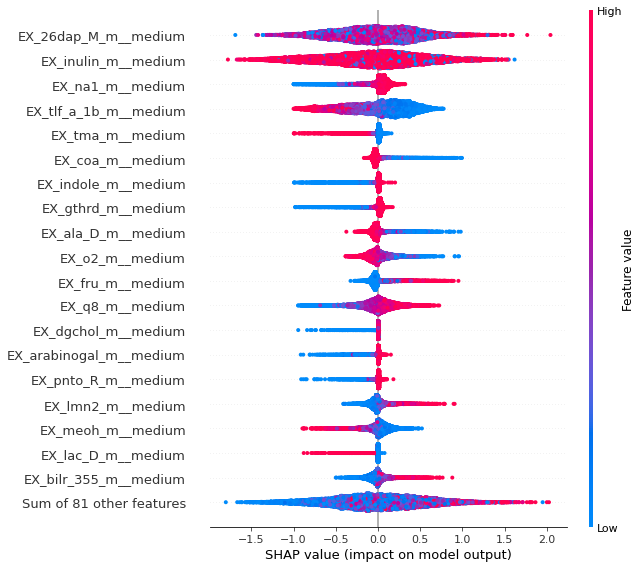

In [6]:
shap.plots.beeswarm(shap_values, max_display=20, order=shap_values.abs.max(0))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


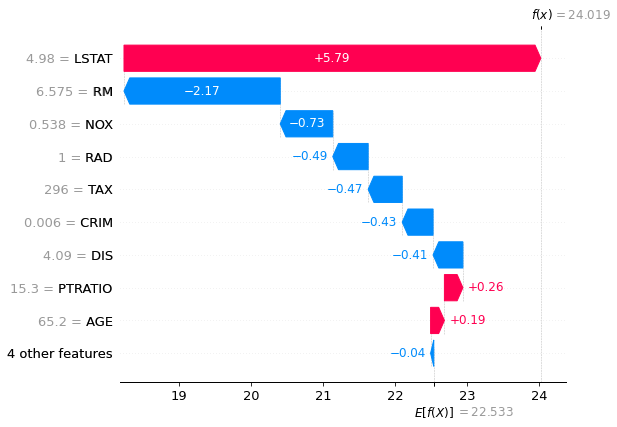

In [24]:


# train an XGBoost model
X, y = shap.datasets.boston()
model = xgboost.XGBRegressor().fit(X, y)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

ValueError: Unknown label type: 'continuous'

In [22]:
model_logreg_fit

LogisticRegression(C=5, class_weight='balanced', intercept_scaling=True,
                   max_iter=1000, solver='liblinear')

In [21]:
explainer = shap.Explainer(model_logreg_fit)
shap_values = explainer(X)

Exception: The passed model is not callable and cannot be analyzed directly with the given masker! Model: LogisticRegression(C=5, class_weight='balanced', intercept_scaling=True,
                   max_iter=1000, solver='liblinear')

In [18]:
explainer = shap.LinearExplainer(model_logreg)
shap_values = explainer(X)

TypeError: __init__() missing 1 required positional argument: 'masker'